In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00


In [4]:
cd "/content/drive/MyDrive/SeminartalkVAEsNFs"

/content/drive/.shortcut-targets-by-id/1qh7NuR-rtGC8StBSNfKzmvFEjuhnsnEn/SeminartalkVAEsNFs


In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# nflows imports for the model
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.coupling import AffineCouplingTransform
from nflows.transforms.base import CompositeTransform


In [6]:
import torch
import torch.nn as nn
from torch.distributions import normal
from torch.distributions.independent import Independent
from nflows.flows import Flow
from nflows.transforms import CompositeTransform, AffineCouplingTransform
from tqdm import tqdm
import matplotlib.pyplot as plt

# Ensure you have the required libraries:
# pip install torch nflows tqdm matplotlib

# --- Step 1: Define a More Interesting Target (Gaussian Mixture Model) --- CORRECTED
class GaussianMixtureDistribution:
    """
    Creates a 2D distribution from a mixture of two separate Gaussians.
    This requires the flow to learn a non-linear "tearing" transformation.
    """
    def __init__(self, device='cpu'):
        self.device = device

        means = torch.tensor([
            [-2.0, 0.0],
            [2.0, 0.0]
        ], device=device)

        stds = torch.tensor([
            [0.5, 0.8],
            [0.5, 0.8]
        ], device=device)

        mixture_weights = torch.distributions.Categorical(
            torch.tensor([0.5, 0.5], device=device)
        )

        # --- FIX 1: Define components correctly ---
        # 1. Create a Normal distribution with a batch shape of (2, 2).
        base_dists = torch.distributions.Normal(means, stds)
        # 2. Use Independent to re-interpret the last batch dimension (dim 1)
        #    as the event dimension.
        #    batch_shape: (2, 2) -> (2,)
        #    event_shape: ()     -> (2,)
        component_distributions = Independent(base_dists, reinterpreted_batch_ndims=1)

        self.dist = torch.distributions.MixtureSameFamily(
            mixture_distribution=mixture_weights,
            component_distribution=component_distributions
        )
        print(f"Created a Gaussian Mixture Distribution with peaks at x=-2 and x=+2.")

    def sample(self, n_samples_shape):
        """Samples from the mixture distribution."""
        return self.dist.sample(n_samples_shape)

    def log_prob(self, xy_batch):
        """
        Calculates the log probability for a batch of points.
        """
        return self.dist.log_prob(xy_batch)

# --- Define a simple neural network (Unchanged) ---
class ContextNet(nn.Module):
    def __init__(self, in_features, out_features, hidden_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden_features), nn.ReLU(),
            nn.Linear(hidden_features, hidden_features), nn.ReLU(),
            nn.Linear(hidden_features, out_features)
        )
    def forward(self, inputs, context=None):
        return self.net(inputs)

# --- Step 2: Define the Normalizing Flow Model (Unchanged) ---
def create_normalizing_flow(num_layers=8, hidden_features=128): # A bit more capacity
    base_dist = StandardNormal(shape=[2])
    transforms = []
    for i in range(num_layers):
        mask = torch.zeros(2); mask[i % 2] = 1
        transforms.append(
            AffineCouplingTransform(
                mask=mask,
                transform_net_create_fn=lambda in_feat, out_feat: ContextNet(in_feat, out_feat, hidden_features)
            )
        )
    transform = CompositeTransform(transforms)
    flow = Flow(transform, base_dist)
    return flow

# --- Step 3: The Training Loop (Unchanged from previous fix) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate our NEW target distribution
mixture_dist = GaussianMixtureDistribution(device=device)
model = create_normalizing_flow().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



num_iter = 4000
batch_size = 512

print(f"\nTraining Normalizing Flow on {device}...")
model.train()
pbar = tqdm(range(num_iter), desc="Training NF")
for i in pbar:
    x = mixture_dist.sample((batch_size,))
    loss = -model.log_prob(inputs=x).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        pbar.set_postfix(loss=f"{loss.item():.4f}")
print("Training finished!")



Created a Gaussian Mixture Distribution with peaks at x=-2 and x=+2.

Training Normalizing Flow on cuda...


Training NF: 100%|██████████| 4000/4000 [01:14<00:00, 53.93it/s, loss=2.6208]

Training finished!


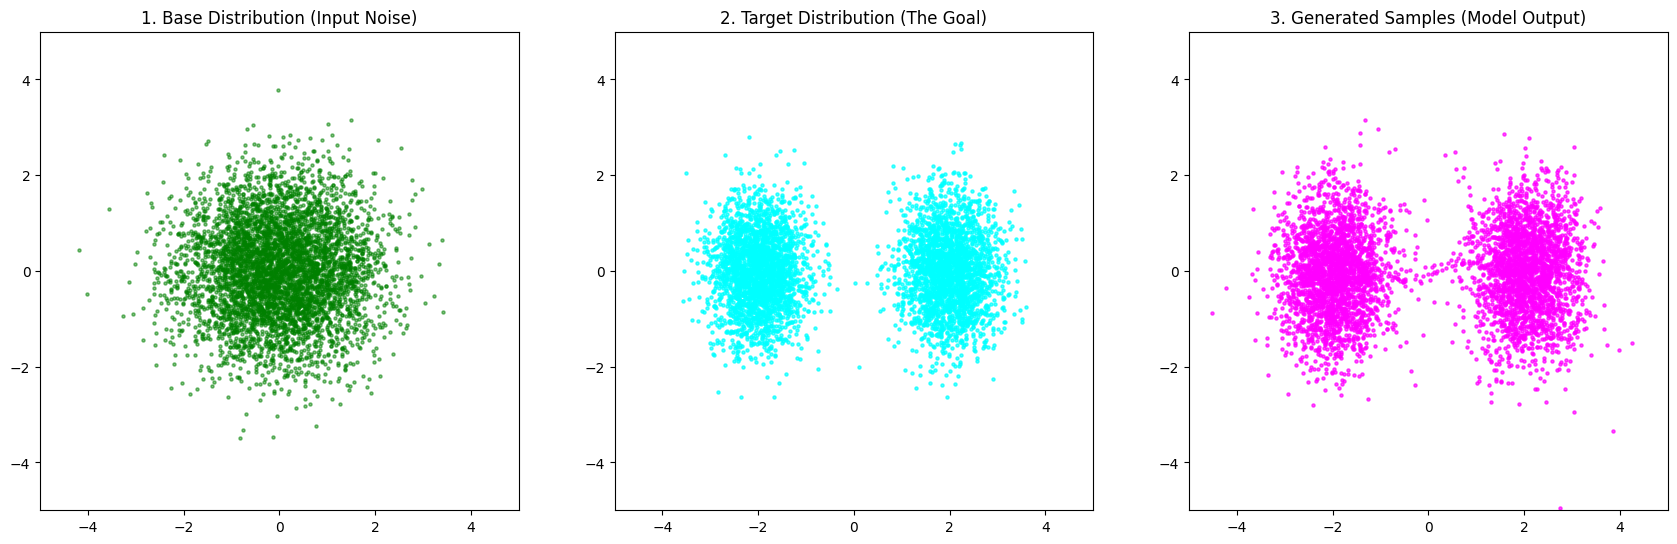

In [7]:
# --- Step 4: Sampling and Visualization (Unchanged from previous fix) ---
model.eval()
base_dist = StandardNormal(shape=[2])
with torch.no_grad():
    base_samples = base_dist.sample(5000).cpu().numpy()
    generated_samples = model.sample(5000).cpu().numpy()

original_samples = mixture_dist.sample((5000,)).cpu().numpy()

# Visualization
plt.style.use('default')
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
#fig.suptitle('Normalizing Flow: Learning a Double-Peaked Gaussian Mixture', fontsize=20)

axes[0].scatter(base_samples[:, 0], base_samples[:, 1], s=5, alpha=0.5, c='green')
axes[0].set_title('1. Base Distribution (Input Noise)')
axes[0].set_aspect('equal', adjustable='box'); axes[0].set_xlim(-5, 5); axes[0].set_ylim(-5, 5)

axes[1].scatter(original_samples[:, 0], original_samples[:, 1], s=5, alpha=0.7, c='cyan')
axes[1].set_title('2. Target Distribution (The Goal)')
axes[1].set_aspect('equal', adjustable='box'); axes[1].set_xlim(-5, 5); axes[1].set_ylim(-5, 5)

axes[2].scatter(generated_samples[:, 0], generated_samples[:, 1], s=5, alpha=0.7, c='magenta')
axes[2].set_title('3. Generated Samples (Model Output)')
axes[2].set_aspect('equal', adjustable='box'); axes[2].set_xlim(-5, 5); axes[2].set_ylim(-5, 5)

plt.show()

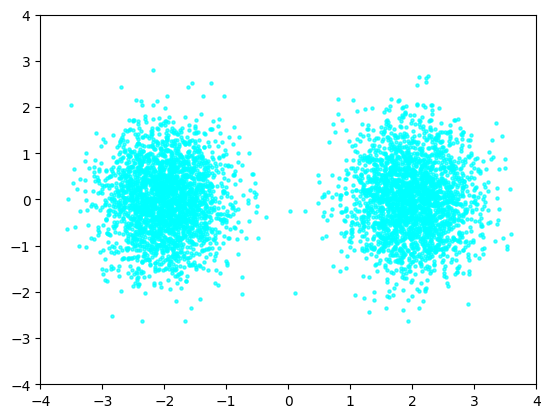

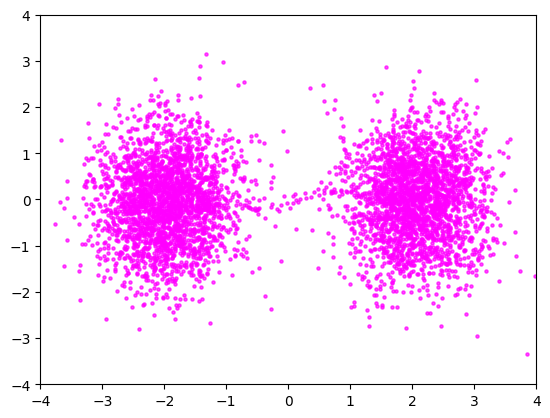

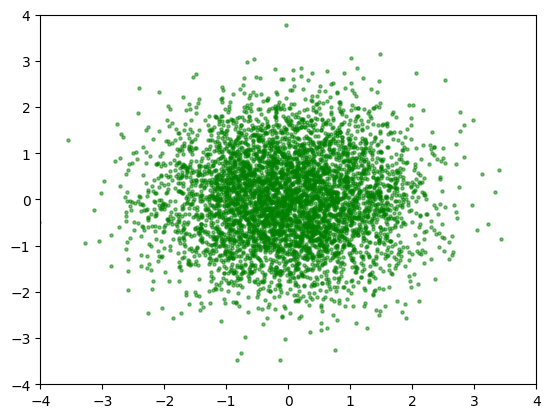

In [9]:
plt.scatter(original_samples[:, 0], original_samples[:, 1], s=5, alpha=0.7, c='cyan')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.scatter(generated_samples[:, 0], generated_samples[:, 1], s=5, alpha=0.7, c='magenta')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

plt.scatter(base_samples[:, 0], base_samples[:, 1], s=5, alpha=0.5, c='green')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()